![image.png](attachment:image.png)

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV

## nao funciona "from sklearn.metrics import plot_confusion_matrix"

In [6]:
#Carregue a base X_train_combined.csv
X_train = pd.read_csv("/content/X_train_combined.csv", index_col=0)
#Carregue a base X_test_combined.csv
X_test = pd.read_csv("/content/X_test_combined.csv", index_col=0)
#Carregue a base y_train.tx
y_train = pd.read_csv("/content/y_train.txt", delim_whitespace=True, header=None)
#Carregue a base y_test.txt
y_test = pd.read_csv("/content/y_test.txt", delim_whitespace=True, header=None)

### 2. Calcule os ```ccp_alphas```.

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

In [7]:
#árvore com min_samples_leaf=20
modelo = DecisionTreeClassifier(min_samples_leaf=20).fit(X_train, y_train)
## Obter a importância das top 3 variáveis
top3 = np.argpartition(modelo.feature_importances_, -3)[-3:]

In [8]:
%%time
## Inicializa um modelo de árvore de decisão para determinar o caminho de poda de complexidade de custo
modelo_clf = DecisionTreeClassifier(random_state=101)
path = modelo_clf.cost_complexity_pruning_path(X_train.iloc[:, top3], y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
#Loop sobre os valores de ccp_alpha para treinar os modelos correspondentes
models = []
for ccp_alpha in ccp_alphas:
    modelo = DecisionTreeClassifier(min_samples_leaf=20, ccp_alpha=ccp_alpha, random_state=101).fit(X_train.iloc[:, top3], y_train)
    models.append(modelo)

CPU times: user 9.04 s, sys: 19.9 ms, total: 9.06 s
Wall time: 9.1 s


### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [9]:
#número total de elementos
ccp_alphas.size

368

In [ ]:
%%time
#Seleciona os valores únicos de ccp_alpha que são únicos e positivos
ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])
clf = DecisionTreeClassifier(random_state=2360873)
grid_parametros = {"ccp_alpha": ccp_alphas[::10]} # Seleciona cada 10º valor de ccp_alpha

grid = GridSearchCV(estimator = clf, param_grid=grid_parametros,cv=10, verbose=100)
grid.fit(X_train.iloc[:, top3], y_train)

### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

In [29]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.041999,0.003731,0.005591,0.000687,0.0,{'ccp_alpha': 0.0},0.839674,0.828804,0.888435,0.772789,0.808163,0.910204,0.897959,0.877551,0.900680,0.844898,0.856916,0.043064,4
1,0.039851,0.002666,0.005379,0.000938,0.000024,{'ccp_alpha': 2.3758669963906535e-05},0.839674,0.827446,0.888435,0.772789,0.808163,0.910204,0.897959,0.877551,0.900680,0.844898,0.856780,0.043154,5
2,0.040836,0.002911,0.004546,0.000373,0.000111,{'ccp_alpha': 0.00011116710038064663},0.839674,0.827446,0.888435,0.772789,0.808163,0.910204,0.897959,0.877551,0.900680,0.844898,0.856780,0.043154,5
3,0.038719,0.002167,0.004420,0.000311,0.000335,{'ccp_alpha': 0.0003346028291621325},0.839674,0.828804,0.889796,0.772789,0.808163,0.910204,0.897959,0.877551,0.900680,0.844898,0.857052,0.043165,3
4,0.039775,0.002254,0.005117,0.001396,0.000483,{'ccp_alpha': 0.00048297802077654304},0.838315,0.827446,0.889796,0.772789,0.809524,0.911565,0.899320,0.877551,0.902041,0.844898,0.857324,0.043599,2


In [12]:
#Achar o melhor valor encontrado para o hiperparâmetro ccp_alpha
melhor_ccp = grid.best_params_['ccp_alpha']
melhor_modelo = DecisionTreeClassifier(min_samples_leaf=20, ccp_alpha=melhor_ccp, random_state=101)
melhor_modelo.fit(X_test.iloc[:, top3], y_test)

DecisionTreeClassifier(ccp_alpha=0.0036062124242923956, min_samples_leaf=20,
                       random_state=101)

In [13]:
#calcula a acurácia do modelo usando os dados de teste e a função do modelo
acuracia_test = melhor_modelo.score(X_test.iloc[:, top3], y_test)
print(f"Acurácia: {acuracia_test*100:.2f}")

Acurácia: 88.67


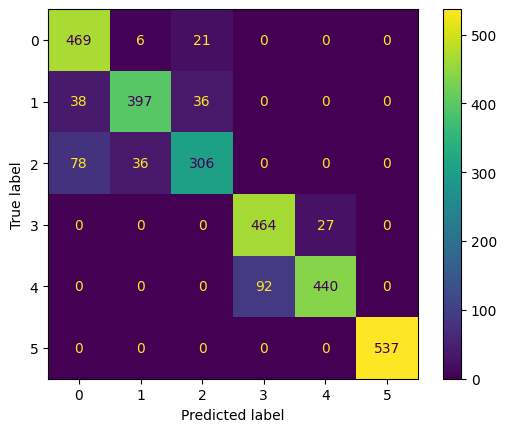

In [14]:
#Calcular a matriz de confusão entre os rótulos reais e as previsões feitas pelo melhor modelo
matrix = confusion_matrix(y_test, melhor_modelo.predict(X_test.iloc[:, top3]))
ConfusionMatrixDisplay(matrix).plot()

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [18]:
#identificar classes mais fáceis e mais difíceis
classificacao = classification_report(y_test, melhor_modelo.predict(X_test.iloc[:, top3]))
print(classificacao)

              precision    recall  f1-score   support

           1       0.80      0.95      0.87       496
           2       0.90      0.84      0.87       471
           3       0.84      0.73      0.78       420
           4       0.83      0.95      0.89       491
           5       0.94      0.83      0.88       532
           6       1.00      1.00      1.00       537

    accuracy                           0.89      2947
   macro avg       0.89      0.88      0.88      2947
weighted avg       0.89      0.89      0.89      2947



In [19]:
#tratando os rótulos de treinamento como binários
y_train_bin = y_train.copy()
y_train_bin[0] = [1 if x==1 else 0 for x in y_train_bin[0]]
y_train_bin.value_counts()

0    6126
1    1226
dtype: int64

In [20]:
#treinando uma arvore de decisao
modelo_binario = DecisionTreeClassifier(min_samples_leaf=20, max_depth=4).fit(X_train, y_train_bin)
# identificadas 3 características mais importantes no modelo treinado
top3_binario = np.argpartition(modelo_binario.feature_importances_, -3)[-3:]
top6 = np.unique(np.append(top3, top3_binario))
top6

array([ 53,  66, 167, 394, 504, 560])

In [23]:
#otimizando hiperparâmetros para encontrar o modelo mais adequado para os dados
%%time
model = DecisionTreeClassifier(min_samples_leaf=20 ,random_state=101)
path = model.cost_complexity_pruning_path(X_train.iloc[:, top6], y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas >= 0])
model = DecisionTreeClassifier(min_samples_leaf=20)
params = {"ccp_alpha": ccp_alphas[::10]}
grid = GridSearchCV(model, param_grid=params, cv=10, verbose=100)
grid.fit(X_train.iloc[:, top6], y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10; 1/9] START ccp_alpha=0.0..............................................
[CV 1/10; 1/9] END ...............ccp_alpha=0.0;, score=0.840 total time=   0.0s
[CV 2/10; 1/9] START ccp_alpha=0.0..............................................
[CV 2/10; 1/9] END ...............ccp_alpha=0.0;, score=0.829 total time=   0.0s
[CV 3/10; 1/9] START ccp_alpha=0.0..............................................
[CV 3/10; 1/9] END ...............ccp_alpha=0.0;, score=0.888 total time=   0.0s
[CV 4/10; 1/9] START ccp_alpha=0.0..............................................
[CV 4/10; 1/9] END ...............ccp_alpha=0.0;, score=0.773 total time=   0.0s
[CV 5/10; 1/9] START ccp_alpha=0.0..............................................
[CV 5/10; 1/9] END ...............ccp_alpha=0.0;, score=0.808 total time=   0.1s
[CV 6/10; 1/9] START ccp_alpha=0.0..............................................
[CV 6/10; 1/9] END ...............ccp_alpha=0.0;

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(min_samples_leaf=20),
             param_grid={'ccp_alpha': array([0.00000000e+00, 2.37586700e-05, 1.11167100e-04, 3.34602829e-04,
       4.82978021e-04, 8.80571911e-04, 1.42511838e-03, 2.87528035e-03,
       9.55046040e-03])},
             verbose=100)

In [25]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.041999,0.003731,0.005591,0.000687,0.0,{'ccp_alpha': 0.0},0.839674,0.828804,0.888435,0.772789,0.808163,0.910204,0.897959,0.877551,0.900680,0.844898,0.856916,0.043064,4
1,0.039851,0.002666,0.005379,0.000938,0.000024,{'ccp_alpha': 2.3758669963906535e-05},0.839674,0.827446,0.888435,0.772789,0.808163,0.910204,0.897959,0.877551,0.900680,0.844898,0.856780,0.043154,5
2,0.040836,0.002911,0.004546,0.000373,0.000111,{'ccp_alpha': 0.00011116710038064663},0.839674,0.827446,0.888435,0.772789,0.808163,0.910204,0.897959,0.877551,0.900680,0.844898,0.856780,0.043154,5
3,0.038719,0.002167,0.004420,0.000311,0.000335,{'ccp_alpha': 0.0003346028291621325},0.839674,0.828804,0.889796,0.772789,0.808163,0.910204,0.897959,0.877551,0.900680,0.844898,0.857052,0.043165,3
4,0.039775,0.002254,0.005117,0.001396,0.000483,{'ccp_alpha': 0.00048297802077654304},0.838315,0.827446,0.889796,0.772789,0.809524,0.911565,0.899320,0.877551,0.902041,0.844898,0.857324,0.043599,2


In [26]:
#Achar o melhor valor encontrado para o hiperparâmetro ccp_alpha
melhor_ccp_alpha = grid.best_params_['ccp_alpha']
melhor_modelo = DecisionTreeClassifier(min_samples_leaf=20, ccp_alpha=melhor_ccp_alpha, random_state=101)
melhor_modelo.fit(X_test.iloc[:, top6], y_test)

DecisionTreeClassifier(ccp_alpha=0.002875280345527772, min_samples_leaf=20,
                       random_state=101)

Acurácia: 91.69


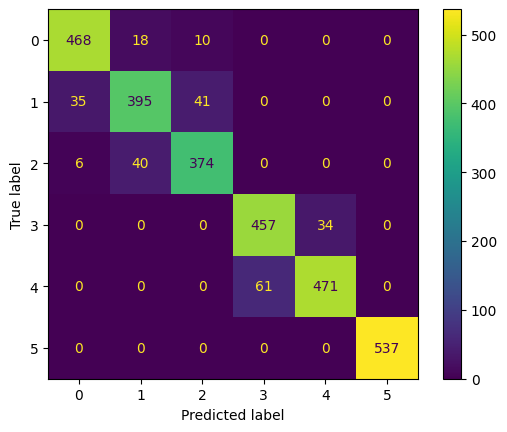

In [27]:
#Calcular a acurácia do modelo usando os dados de teste e a função do modelo
acuracia_test = melhor_modelo.score(X_test.iloc[:, top6], y_test)
print(f"Acurácia: {acuracia_test*100:.2f}")
#Calcular a matriz de confusão entre os rótulos reais e as previsões feitas pelo melhor modelo
matrix = confusion_matrix(y_test, melhor_modelo.predict(X_test.iloc[:, top6]))
ConfusionMatrixDisplay(matrix).plot()

#Conclusao

Utilizando a matriz de confusão visualmente, é possível perceber uma melhor performance. O que mais chamou a atenção foi a classe 2, onde 72 valores que originalmente eram considerados da classe 0 foram redistribuídos para as classes 1 e 2.